# Attack on Diva using trepan, a Decision Tree and the noisy dataset, with filtering

The attack is run on the distance-separated elements without filtering based on the std dev.

In [1]:
from pathlib import Path
import sys
from numba import njit

UTILS_RELATIVE_PATH = "../../../../../"
sys.path.append(UTILS_RELATIVE_PATH)

MLEM_RELATIVE_PATH = "../../../../../../"
sys.path.append(MLEM_RELATIVE_PATH)

LIME_RELATIVE_PATH = "../../../../../../lime/"
sys.path.append(LIME_RELATIVE_PATH)

OUTPUT_FOLDER = Path("experiment_output")
OUTPUT_FOLDER.mkdir(exist_ok=True)

import logging
logging.disable('DEBUG')


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()
import numpy as np
import scipy.spatial.distance as distance
import multiprocessing

np.random.seed(4321)
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from lime.lime_tabular import LimeTabularExplainer # type: ignore
from mlem.utilities import generate_balanced_dataset, save_pickle_bz2, load_pickle_bz2, save_txt

importing the experiment utilities and the mlem module

# Loading the Diva data

loading the Diva RandomForest and the dictionary with all the useful data

In [3]:
from utils.dataloading.diva import load_diva_data, load_diva_randomforest # type: ignore

BB = load_diva_randomforest()
BB_DATA = load_diva_data()

print(classification_report(BB_DATA['y_test'], BB.predict(BB_DATA['X_test'])))

              precision    recall  f1-score   support

           0       0.92      0.95      0.94      2094
           1       0.85      0.77      0.81       745

    accuracy                           0.90      2839
   macro avg       0.89      0.86      0.87      2839
weighted avg       0.90      0.90      0.90      2839



# Creating the data generator

In [4]:
from utils.trepan.trepan_generation import TrePanGenerator
from utils.filtering import filter_elements_std
generator = TrePanGenerator(oracle=BB, oracle_type="rf")

In [5]:
def generate_data_trepan(x, num_samples):
    # num samples is ignored
    gen = generator.generate(BB_DATA['X_train'], size = 20000)
    labels_bb = gen[:, -1]
    features = np.delete(gen, -1, axis=1)
    # the labeling by the BB is done again by the generate_balanced_dataset
    return features
    

# def filter_elements_std(elems, x, std=3):
#     df_ = pd.DataFrame(elems)
#     df_['Dist'] = distance.cdist(elems, [x])
#     mean = df_.Dist.mean()
#     dev = df_.Dist.std()
#     closest = df_[df_['Dist'] < mean+std*dev]
#     return closest.drop(labels=['Dist'], axis=1)

# Generating the lime datasets

In [6]:
test_representatives_x = BB_DATA['X_distance_separated']
test_representatives_y = BB_DATA['y_distance_separated']
n_datasets = len(test_representatives_x)

In [7]:
# from genericpath import isdir
# import shutil
# # cleaning function to delete all but the trepan generated stuff

# for p in [(OUTPUT_FOLDER / f"{i}") for i in range(len(test_representatives_x))]:
#     for base in ("attack", "shadow", "attack_models_train_dataset.csv", "dt.bz2", "statistics_noisy.txt", "dt_report_fidelity.txt"):
#         pp = p / base
#         if pp.exists():
#             if pp.is_dir():
#                 shutil.rmtree(pp)
#             else:
#                 pp.unlink()

In [8]:
def generate_and_save(index, instance):
    # wrapper of the above functions to be able to generate the datasets in parallel
    output_path = OUTPUT_FOLDER / f"{index}"
    output_path.mkdir(exist_ok=True)
    balanced_dataset = generate_balanced_dataset(instance, 5000, BB, generate_data_trepan, filter_elements_std)
    balanced_dataset.to_csv(output_path / "trepan_generated.csv", index=False)
    with open(output_path / "instance.npy", "wb") as f:
        np.save(f, instance)


if not any([Path(OUTPUT_FOLDER / f"{j}" / "trepan_generated.csv").exists() for j in range(len(test_representatives_x))]):
    # with torch.multiprocessing.Pool(processes=8) as pool:
    #     pool.starmap(generate_and_save, [*enumerate(test_representatives_x)])
    for i, el in enumerate(test_representatives_x):
        generate_and_save(i, el)
else:
    print("The trepan generated datasets already exist")

The trepan generated datasets already exist


# Creating the Decision Trees

Creating the decision trees <span style="color:red"> if they don't already exist </span>.

In [9]:
from mlem.utilities import create_decision_tree
from utils.attack_evaluation.measures import compute_fidelity_and_reports, save_fidelity_and_reports

def train_decision_tree(datapath, model_name):
    lime_dataset = pd.read_csv(datapath / "trepan_generated.csv")
    X_train, X_test, y_train, y_test = train_test_split(lime_dataset.drop('Target', axis=1).to_numpy(), lime_dataset.Target.to_numpy(), test_size=0.33, random_state=42)
    model_path = datapath / model_name
    if not model_path.exists():
        dt = create_decision_tree(X_train, y_train, use_halving=True, n_jobs=1) 
        save_pickle_bz2(model_path, dt)
        statistics = compute_fidelity_and_reports([("trepan_generated_test", X_test, y_test), ("bb_test_set", BB_DATA['X_test'], BB_DATA['y_test'])], ("decision_tree", dt), ("black_box", BB))
        save_fidelity_and_reports(datapath / "dt_report_fidelity.txt", statistics)
        # save_txt(datapath / "dt_classification_report.txt", classification_report(y_test, dt.predict(X_test)))

In [10]:
models_name = "dt.bz2"
if not any([Path(OUTPUT_FOLDER / f"{j}" / "dt.bz2").exists() for j in range(len(test_representatives_x))]):
    with multiprocessing.Pool(8) as pool:
        pool.starmap(train_decision_tree, [(Path(OUTPUT_FOLDER / f"{i}"), models_name) for i in range(len(test_representatives_x))])
else:
    print("The DecisionTrees already exist")

The DecisionTrees already exist


# Attack on the Decision Trees to create the attack models

Attack on the decision trees using the <span style="background: green">noisy dataset</span> labeled by the decision trees to create the shadow models.

In [11]:
noisy_dataset_x = pd.DataFrame(BB_DATA['X_validation_noisy'])
noisy_dataset_y = pd.DataFrame(BB_DATA['y_validation_noisy'])
categorical_features_mask = BB_DATA['categorical_features_mask']

Creating the shadow models and the attack models.

In [12]:
from mlem.shadow_models import ShadowModelsManager
from mlem.utilities import create_adaboost
from mlem.attack_models import AttackModelsManager, AttackStrategy

In [13]:
def compute_statistics_local_model(dataset, true_y, local_model, black_box, output_folder, filename):
    local_y = local_model.predict(dataset.to_numpy())
    local_bb = black_box.predict(dataset.to_numpy())

    report_local = classification_report(true_y.to_numpy(), local_y)
    report_bb    = classification_report(true_y.to_numpy(), local_bb)

    fidelity = str(pd.DataFrame(local_y == local_bb).value_counts(normalize=True))

    with open(output_folder / filename, "w") as f:
        f.write("Statistics on the noisy validation dataset\n")
        
        f.write("local model\n")
        f.write(report_local)

        f.write("\nblack box\n")
        f.write(report_bb)

        f.write("\nFidelity between the local model and the black box\n")
        f.write(fidelity)

Run the attack only if it hasn't already been run

In [14]:
if not any([(OUTPUT_FOLDER / f"{i}" / "attack").exists() for i in range(len(test_representatives_x))]):
    
    for path in [OUTPUT_FOLDER / f"{i}" for i in range(len(test_representatives_x))]:
        # load the local tree and label the noisy dataset
        if (path / "dt.bz2").exists():
            local_tree = load_pickle_bz2(path / "dt.bz2")

            # compute fidelity and performances on the noisy dataset.
            # NOTE: The labels associated with the noisy dataset are the same of the clean one.
            compute_statistics_local_model(noisy_dataset_x, noisy_dataset_y, local_tree, BB, path, "statistics_noisy.txt")

            x_attack = noisy_dataset_x.to_numpy()    
            y_attack = local_tree.predict(x_attack)

            path_shadow = str(path / "shadow")

            shadow_models = ShadowModelsManager(
                n_models=4,
                results_path=path_shadow,
                test_size=0.5,
                random_state=123,
                model_creator_fn=create_adaboost,
                categorical_mask=categorical_features_mask
            )
            # x_attack is the noisy dataset
            shadow_models.fit(x_attack, y_attack)

            # extracting the dataset for the attack models
            attack_models_dataset = shadow_models.get_attack_dataset()

            # saving the attack dataset
            attack_models_dataset.to_csv(path / "attack_models_train_dataset.csv", index=False)

            # Creating the attack model for each label using Adaboost
            path_attack = str(path / "attack")
            attack_models = AttackModelsManager(
                    results_path=path_attack, model_creator_fn=create_adaboost, attack_strategy=AttackStrategy.ONE_PER_LABEL
            )
            
            attack_models.fit(attack_models_dataset)
            print(f"Attack on {path} completed")
        else:
            print(f"Couldn't find model at {path}")
else:
    print("The attack models already exist")

[INFO OVERSAMPLE] Specified ratio too low: skipping oversampling
Attack on experiment_output/0 completed
[INFO OVERSAMPLE] Specified ratio too low: skipping oversampling
Attack on experiment_output/1 completed
[INFO OVERSAMPLE] Specified ratio too low: skipping oversampling
Attack on experiment_output/2 completed
[INFO OVERSAMPLE] Specified ratio too low: skipping oversampling
Attack on experiment_output/3 completed
[INFO OVERSAMPLE] Specified ratio too low: skipping oversampling
Attack on experiment_output/4 completed
[INFO OVERSAMPLE] Specified ratio too low: skipping oversampling
Attack on experiment_output/5 completed
[INFO OVERSAMPLE] Specified ratio too low: skipping oversampling
Attack on experiment_output/6 completed
[INFO OVERSAMPLE] Specified ratio too low: skipping oversampling
Attack on experiment_output/7 completed
[INFO OVERSAMPLE] Specified ratio too low: skipping oversampling
Attack on experiment_output/8 completed
Couldn't find model at experiment_output/9
[INFO OVERSA

By looking at the test reports of the attack models, it seems that they <span style="background: green">perform better on the class 1</span> with an accuracy of $\simeq .62$, while the accuracy on the class 0 is $\simeq .51$.

# Creating the ensembles

In [15]:
from mlem.ensemble import HardVotingClassifier, SoftVotingClassifier, KMostSureVotingClassifier
from utils.attack_evaluation import evaluate_attack

In [16]:
def check_exists(i):
    atkm0 = (OUTPUT_FOLDER / f"{i}" / "attack" / "0" / "model.pkl.bz2").exists()
    return atkm0 and (OUTPUT_FOLDER / f"{i}" / "attack" / "1" / "model.pkl.bz2").exists()
ATTACK_MODELS_NUMBERS = [i for i in range(len(test_representatives_x)) if  check_exists(i)]
print(*ATTACK_MODELS_NUMBERS, sep=" ")    
attack_models_0 = [load_pickle_bz2(OUTPUT_FOLDER / f"{i}" / "attack" / "0" / "model.pkl.bz2") for i in ATTACK_MODELS_NUMBERS]
attack_models_1 = [load_pickle_bz2(OUTPUT_FOLDER / f"{i}" / "attack" / "1" / "model.pkl.bz2") for i in ATTACK_MODELS_NUMBERS]

0 1 2 3 4 5 6 7 8 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39


## Hard Voting

In [17]:
hv0 = HardVotingClassifier(classifiers=attack_models_0)
hv1 = HardVotingClassifier(classifiers=attack_models_1)

report full
              precision    recall  f1-score   support

          in       0.70      0.98      0.82      6624
         out       0.34      0.02      0.04      2839

    accuracy                           0.69      9463
   macro avg       0.52      0.50      0.43      9463
weighted avg       0.59      0.69      0.58      9463


Class 0
              precision    recall  f1-score   support

          in       0.70      0.98      0.81      4965
         out       0.35      0.03      0.05      2165

    accuracy                           0.69      7130
   macro avg       0.52      0.50      0.43      7130
weighted avg       0.59      0.69      0.58      7130


Class 1
              precision    recall  f1-score   support

          in       0.71      1.00      0.83      1659
         out       0.00      0.00      0.00       674

    accuracy                           0.71      2333
   macro avg       0.36      0.50      0.42      2333
weighted avg       0.51      0.71      0.59 

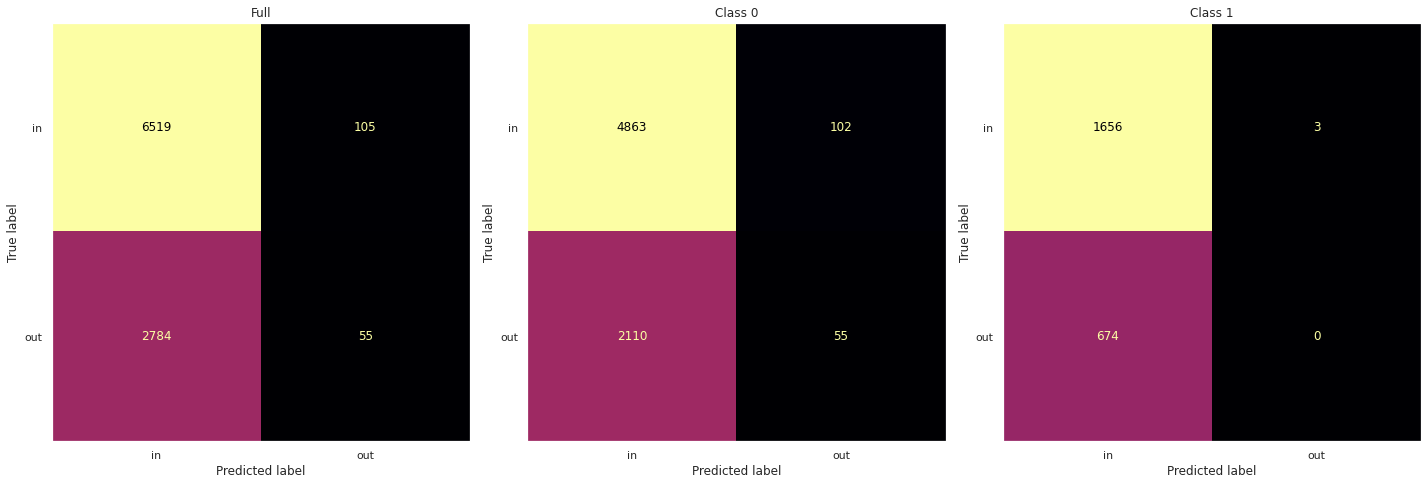

In [18]:
evaluate_attack(hv0, hv1, BB, BB_DATA)

## Soft Voting

In [19]:
sv0 = SoftVotingClassifier(classifiers=attack_models_0)
sv1 = SoftVotingClassifier(classifiers=attack_models_1)

report full
              precision    recall  f1-score   support

          in       0.70      0.99      0.82      6624
         out       0.36      0.01      0.02      2839

    accuracy                           0.70      9463
   macro avg       0.53      0.50      0.42      9463
weighted avg       0.60      0.70      0.58      9463


Class 0
              precision    recall  f1-score   support

          in       0.70      0.99      0.82      4965
         out       0.37      0.01      0.03      2165

    accuracy                           0.69      7130
   macro avg       0.53      0.50      0.42      7130
weighted avg       0.60      0.69      0.58      7130


Class 1
              precision    recall  f1-score   support

          in       0.71      1.00      0.83      1659
         out       0.00      0.00      0.00       674

    accuracy                           0.71      2333
   macro avg       0.36      0.50      0.42      2333
weighted avg       0.51      0.71      0.59 

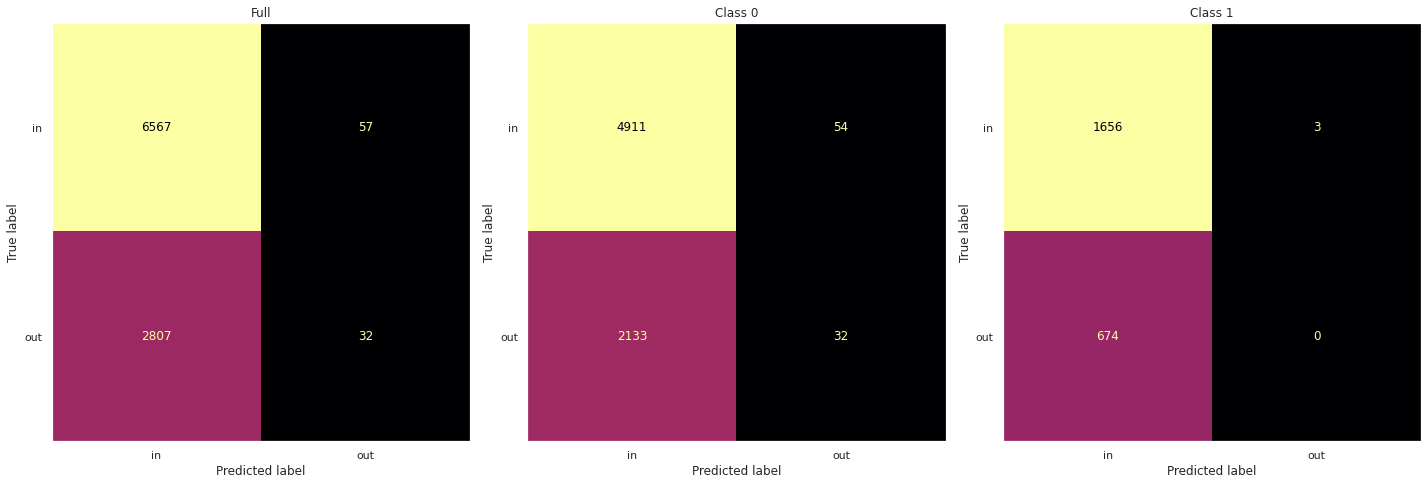

In [20]:
evaluate_attack(sv0, sv1, BB, BB_DATA)